### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта
## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 7


### Дисциплина: Методы машинного обучения
##### Студент:  Маслова Анастасия
##### Группа:   НКНбд-01-21
## Москва 2024
***
### Вариант 29

1. Набор данных: imagenette/160px-v2 с изменением разрешения до 32х32

2. Диапазон классов: 0, 2, 4, 6

3. Архитектура автокодировщика: MLP

4. Показатель качества: максимальная ошибка (MaxErr) для ошибки реконструкции

5. Показатель качества бинарной классификации:

индекс Жаккара, равный TP/(TP + FP + FN)


Решение:


1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки. Оставьте в обучающей и тестовой выборках диапазон классов, указанных в индивидуальном задании. Если изображения цветные (с тремя каналами), то перекодируйте их в одноцветные (оттенки серого).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd
import time
import sys
from PIL import Image, ImageOps
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
ds = tfds.load("imagenette/160px-v2", split="train")
df = tfds.as_dataframe(ds)
df.head(3)

,image,label
0,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",2
1,"[[[99, 97, 98], [171, 169, 170], [220, 218, 21...",6
2,"[[[2, 6, 18], [5, 9, 20], [5, 12, 22], [6, 13,...",7


In [3]:
df.shape

(9469, 2)

In [4]:
df.label.unique()

array([2, 6, 7, 3, 4, 5, 8, 0, 1, 9])

In [5]:
df.label.value_counts()

label
2    993
0    963
6    961
9    960
5    956
1    955
8    951
4    941
7    931
3    858
Name: count, dtype: int64

In [6]:
x = df[df['label'] == 0]
y = df[df['label'] == 2]
v = df[df['label'] == 4]
z = df[df['label'] == 6]
x['label'] = 0
y['label'] = 1
v['label'] = 2
z['label'] = 3
df1 = pd.concat([x, y, v, z])
y = df1['label']
X = df1['image']

<ipython-input-6-022e9db43411>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['label'] = 0
<ipython-input-6-022e9db43411>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['label'] = 1
<ipython-input-6-022e9db43411>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
import random

def plot_random_sample(images):
    n = 10
    imgs = random.sample(list(images), n)

    num_row = 2
    num_col = 5

    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    # For every image
    for i in range(num_row * num_col):
        # Read the image
        img = imgs[i]
        # Display the image
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

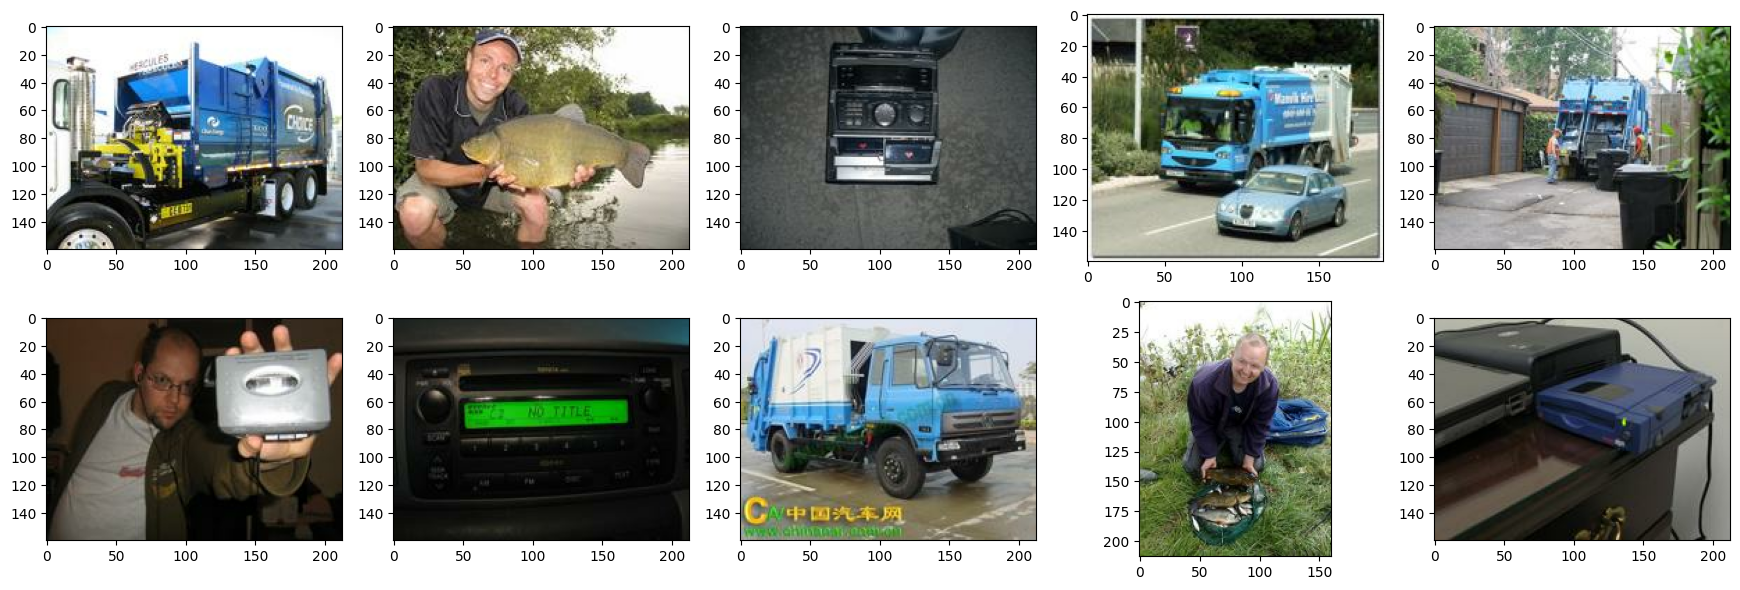

In [9]:
plot_random_sample(X_train)

In [10]:
for i in range(len(X_train)):
    img = Image.fromarray(np.array(X_train.iloc[i]))
    X_train.iloc[i] = np.array(ImageOps.grayscale(img))
for i in range(len(X_test)):
    img = Image.fromarray(np.array(X_test.iloc[i]))
    X_test.iloc[i] = np.array(ImageOps.grayscale(img))

In [11]:
X_tr = np.zeros(shape=(X_train.shape[0],32,32), dtype=np.float32)
X_te = np.zeros(shape=(X_test.shape[0],32,32), dtype=np.float32)

In [12]:
for i in range(len(X_tr)):
    X_tr[i,:,:] = np.array(Image.fromarray(X_train.iloc[i]).resize((32,32)))
for i in range(len(X_te)):
    X_te[i,:,:] = np.array(Image.fromarray(X_test.iloc[i]).resize((32,32)))

In [13]:
X_tr.shape

(3086, 32, 32)

2. Постройте для набора данных график логарифмического правдоподобия профиля в зависимости от числа главных компонент и определите размерность латентного пространства.

Показатель качества: максимальная ошибка (MaxErr) для ошибки реконструкции

In [14]:
from sklearn.decomposition import PCA
from sklearn.metrics import max_error
from scipy.stats import multivariate_normal
import warnings
warnings.simplefilter("ignore", RuntimeWarning)  # for some NaN values

# Function to calculate log likelihood of PCA from eigenvalues

def log_likelihood(evals):

    Lmax = len(evals)
    ll = np.arange(0.0, Lmax)

    for L in range(Lmax):

        group1 = evals[0 : L + 1]  # Divide Eigenvalues in two groups
        group2 = evals[L + 1 : Lmax]

        mu1 = np.mean(group1)
        mu2 = np.mean(group2)

        sigma = (np.sum((group1 - mu1) ** 2) + np.sum((group2 - mu2) ** 2)) / Lmax

        ll_group1 = np.sum(multivariate_normal.logpdf(group1, mu1, sigma))
        ll_group2 = np.sum(multivariate_normal.logpdf(group2, mu2, sigma))

        ll[L] = ll_group1 + ll_group2

    return ll

In [15]:
X1 = np.reshape(X_tr, (X_tr.shape[0], 32 * 32))
X2 = np.reshape(X_te, (X_te.shape[0], 32 * 32))

In [16]:
X_rank = np.linalg.matrix_rank(X1)
K_linspace = np.linspace(1, 0.75 * X_rank, 10, dtype=int)
Ks = np.unique(np.append([1, 5, 10, 20], K_linspace))

MaxErr_train = np.arange(len(Ks))

In [17]:
for index, K in enumerate(Ks):
    pca = PCA(n_components=K)
    Xtrain_transformed = pca.fit_transform(X1)
    Xtrain_proj = pca.inverse_transform(Xtrain_transformed)
    MaxErr_train[index] = np.max(np.abs(X1 - Xtrain_proj), axis=1).mean()

In [18]:
X_rank

1024

In [19]:
n_samples, n_features = X1.shape
Kmax = min(n_samples, n_features)
pca = PCA(n_components=Kmax)
X_transformed = pca.fit_transform(X1)
evals = pca.explained_variance_ # eigenvalues in descending order
ll = log_likelihood(evals)
# Fraction of variance explained
fraction_var = np.cumsum(evals[0:50] / np.sum(evals))

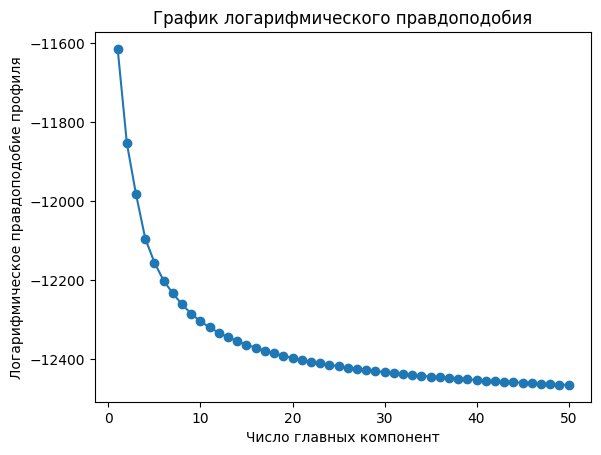

In [20]:
fig, ax = plt.subplots()
xs = np.arange(1, 51)
ys = ll[0:50]
plt.xlabel("Число главных компонент")
plt.ylabel("Логарифмическое правдоподобие профиля")
plt.title("График логарифмического правдоподобия")
ax.plot(xs, ys, marker="o")
plt.show()

3. Создайте и обучите на обучающей выборке автокодировщик архитектуры, указанной в индивидуальном задании, с размерностью скрытого представления, равной размерности латентного пространства, определенной в п.2. Подберите такие параметры, как функции активации, оптимизатор, начальная скорость обучения, размер мини-пакета и др. самостоятельно, обеспечивая обучение нейронных сетей. Визуализируйте несколько исходных и восстановленных автокодировщиком изображений.  


Архитектура автокодировщика: MLP

In [21]:
x_train1 = X_tr.astype('float32') / 255.
x_test1  = X_te.astype('float32') / 255.

In [22]:
x_train1.shape, x_test1.shape

((3086, 32, 32), (772, 32, 32))

In [23]:
x_trainMLP = x_train1.reshape((len(x_train1), np.prod(x_train1.shape[1:])))
x_testMLP  = x_test1.reshape((len(x_test1), np.prod(x_test1.shape[1:])))
x_trainMLP.shape, x_testMLP.shape

((3086, 1024), (772, 1024))

In [66]:
 def create_autoencoders (feature_layer_dim = 1024):
    input_img = Input(shape = (1024,), name = 'Input_Layer')
    encoded = Dense(feature_layer_dim, activation = 'relu', name = 'Encoded_Features')(input_img)
    decoded = Dense(1024, activation = 'sigmoid', name = 'Decoded_Input')(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    encoded_input = Input(shape = (feature_layer_dim,))
    decoder = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder(encoded_input))
    return autoencoder, encoder, decoder

In [67]:
autoencoder, encoder, decoder = create_autoencoders(1024)
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy)
history = autoencoder.fit(x_trainMLP, x_trainMLP,
                    epochs=80,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_testMLP, x_testMLP),
                    verbose = 1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]);

Epoch 1/80
25/25 [==============================] - 2s 63ms/step - loss: 0.6537 - val_loss: 0.6248
Epoch 2/80
25/25 [==============================] - 2s 70ms/step - loss: 0.6167 - val_loss: 0.6081
Epoch 3/80
25/25 [==============================] - 1s 56ms/step - loss: 0.6038 - val_loss: 0.5967
Epoch 4/80
25/25 [==============================] - 1s 54ms/step - loss: 0.5957 - val_loss: 0.6102
Epoch 5/80
25/25 [==============================] - 2s 61ms/step - loss: 0.5940 - val_loss: 0.5858
Epoch 6/80
25/25 [==============================] - 2s 88ms/step - loss: 0.5859 - val_loss: 0.5820
Epoch 7/80
25/25 [==============================] - 2s 87ms/step - loss: 0.5803 - val_loss: 0.6117
Epoch 8/80
25/25 [==============================] - 1s 56ms/step - loss: 0.5844 - val_loss: 0.5763
Epoch 9/80
25/25 [==============================] - 1s 55ms/step - loss: 0.5750 - val_loss: 0.5727
Epoch 10/80
25/25 [==============================] - 1s 54ms/step - loss: 0.5713 - val_loss: 0.5817
Epoch 11/

In [68]:
def plot_sample(images1, images2):
    n = 10
    imgs = list(images1[0:5]) + list(images2[0:5])
    num_row = 2
    num_col = 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    # For every image
    for i in range(num_row * num_col):
        # Read the image
        img = imgs[i]
        # Display the image
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()

Сверху исходные изображения, снизу - восстановленные

25/25 [==============================] - 0s 6ms/step


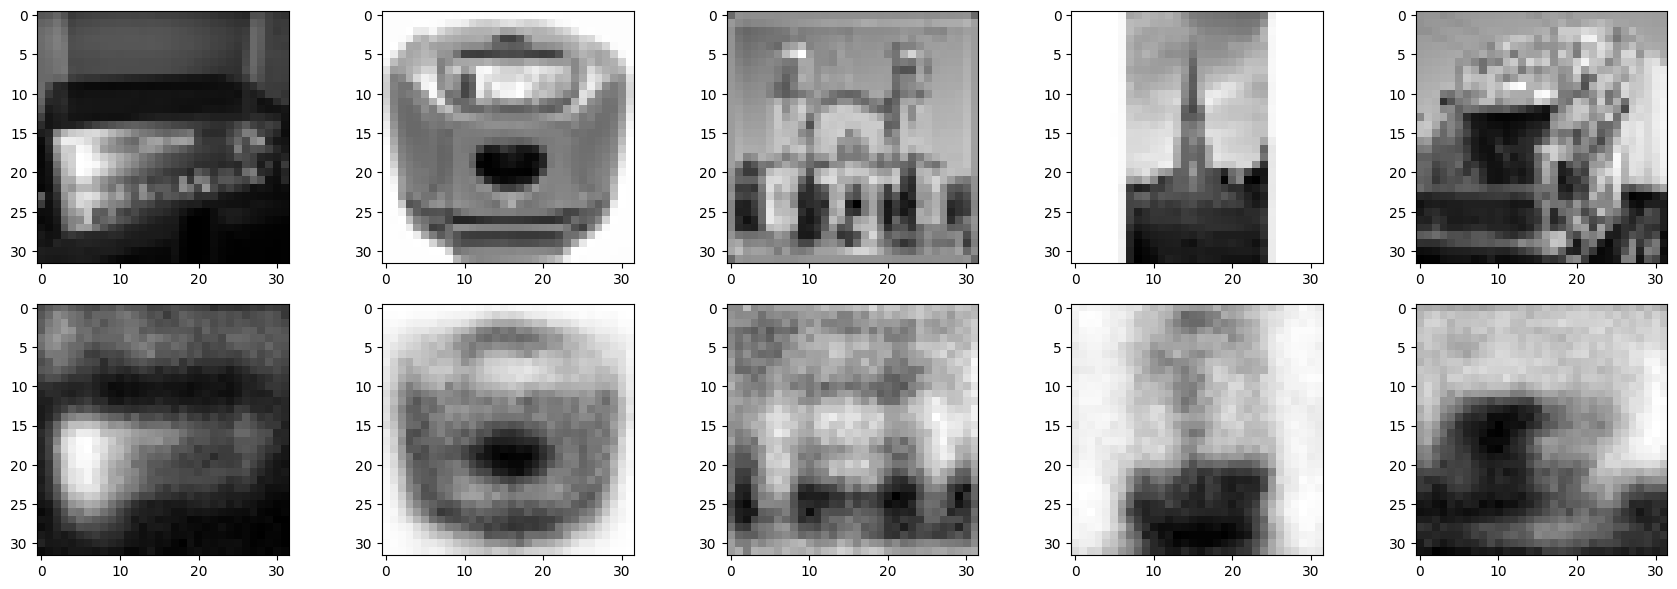

In [69]:
plot_sample(x_testMLP.reshape(x_testMLP.shape[0], 32, 32), autoencoder.predict(x_testMLP).reshape(x_testMLP.shape[0], 32, 32))

4. Оцените качество модели автокодировщика на тестовой выборке по показателю, указанному в индивидуальном задании.


Показатель качества: максимальная ошибка (MaxErr) для ошибки реконструкции

In [70]:
import numpy as np

encoded_imgs = encoder.predict(X2)
decoded_imgs = decoder.predict(encoded_imgs)

error = np.abs(X2 - decoded_imgs)

max_error_per_sample = np.max(error, axis=1)

max_error = np.max(max_error_per_sample)

print("Maximum error (MaxErr):", max_error)


25/25 [==============================] - 0s 4ms/step
Maximum error (MaxErr): 254.0


во всех моих попытках максимальная ошибка колеблется от 254 до 255

В начале я перепутала и оценила не по тому показателю, но все равно оставлю эту часть кода здесь

In [71]:
encoded_imgs = encoder.predict(X2)
decoded_imgs = decoder.predict(encoded_imgs)

intersection = np.logical_and(x_testMLP, decoded_imgs)
union = np.logical_or(x_testMLP, decoded_imgs)

jacquard_index = np.sum(intersection) / np.sum(union)

print("Jacquard Index:", jacquard_index)

25/25 [==============================] - 0s 4ms/step
Jacquard Index: 0.9132066007541828


5. Оставьте в наборах изображения первых двух классов диапазона, указанного в индивидуальном задании первыми. Визуализируйте набор данных на плоскости, соответствующей двум первым латентным признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.


классы: 0, 2


In [72]:
df.head()

,image,label
0,"[[[254, 254, 254], [254, 254, 254], [254, 254,...",2
1,"[[[99, 97, 98], [171, 169, 170], [220, 218, 21...",6
2,"[[[2, 6, 18], [5, 9, 20], [5, 12, 22], [6, 13,...",7
3,"[[[172, 167, 101], [180, 174, 112], [193, 188,...",3
4,"[[[0, 2, 5], [26, 31, 34], [23, 28, 31], [6, 1...",4


In [73]:
x = df[df['label']==0]
x['label']=0
y = df[df['label']==2]
y['label']=1
df_02 = pd.concat([x,y])
df_02.head()

<ipython-input-73-0f3cd8110b0d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['label']=0
<ipython-input-73-0f3cd8110b0d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['label']=1


,image,label
18,"[[[113, 130, 78], [138, 156, 104], [142, 160, ...",0
19,"[[[40, 48, 50], [41, 49, 51], [8, 16, 18], [0,...",0
30,"[[[57, 83, 35], [56, 82, 34], [55, 81, 33], [5...",0
39,"[[[252, 255, 255], [239, 242, 247], [233, 236,...",0
41,"[[[79, 139, 176], [80, 140, 177], [80, 140, 17...",0


In [74]:
df_02.shape

(1956, 2)

In [75]:
y_02 = df_02['label']
X_02 = df_02['image']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_02, y_02, test_size=0.2, random_state=42)

In [77]:
for i in range(len(X_train)):
    img = Image.fromarray(np.array(X_train.iloc[i]))
    X_train.iloc[i] = np.array(ImageOps.grayscale(img))
for i in range(len(X_test)):
    img = Image.fromarray(np.array(X_test.iloc[i]))
    X_test.iloc[i] = np.array(ImageOps.grayscale(img))

In [78]:
X_tr = np.zeros(shape=(X_train.shape[0],32,32), dtype=np.float32)
X_te = np.zeros(shape=(X_test.shape[0],32,32), dtype=np.float32)

In [79]:
X_tr.shape

(1564, 32, 32)

In [80]:
for i in range(len(X_tr)):
    X_tr[i,:,:] = np.array(Image.fromarray(X_train.iloc[i]).resize((32,32)))
for i in range(len(X_te)):
    X_te[i,:,:] = np.array(Image.fromarray(X_test.iloc[i]).resize((32,32)))

In [81]:
X_tr = X_tr.reshape(X_tr.shape[0], 32*32)
X_te = X_te.reshape(X_te.shape[0], 32*32)
X_tr = X_tr.astype('float32') / 255.
X_te = X_te.astype('float32') / 255

25/25 [==============================] - 0s 11ms/step


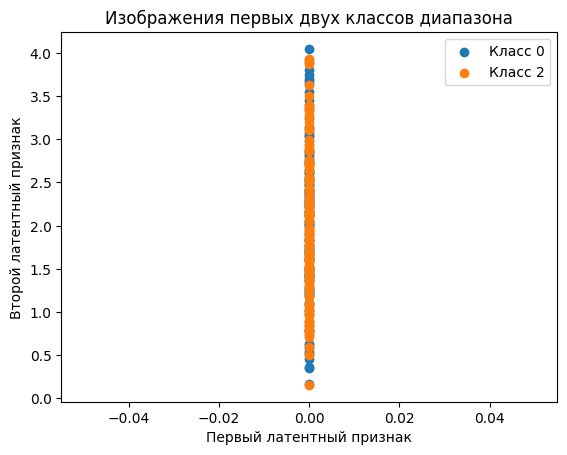

In [82]:
zxc = pd.concat([pd.DataFrame(X_tr),pd.DataFrame(y_train)],axis=1)
zxc0 = zxc[zxc.iloc[:,1024] == 0]
zxc1 = zxc[zxc.iloc[:,1024] == 1]
e0 = encoder.predict(zxc0.iloc[:,:1024])
e1 = encoder.predict(zxc1.iloc[:,:1024])
plt.scatter(e0[:,0], e0[:,1], label='Класс 0')
plt.scatter(e1[:,0], e1[:,1], label='Класс 2')
plt.xlabel('Первый латентный признак')
plt.ylabel('Второй латентный признак')
plt.title('Изображения первых двух классов диапазона')
plt.legend();

6. Выполните бинарную классификацию изображений по латентным (скрытым) признакам и всем признакам при помощи классификатора метода ближайших соседей (kNN). Оцените бинарный классификатор, указанный в индивидуальном задании, для двух построенных классификаторов.


Показатель качества бинарной классификации:

индекс Жаккара, равный TP/(TP + FP + FN)

In [83]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

Классификация по скрытым признакам

In [84]:
from sklearn.neighbors import KNeighborsClassifier
encoded_imgs = encoder.predict(X_tr)
decoded_imgs = decoder.predict(encoded_imgs)
knn1 = KNeighborsClassifier(n_neighbors=7).fit(encoded_imgs, y_train)
accuracy = knn1.score(encoder.predict(X_te), y_test)
print(accuracy)

13/13 [==============================] - 0s 6ms/step
0.7806122448979592


Классификация по всем признакам

In [85]:
knn2 = KNeighborsClassifier(n_neighbors=7).fit(X_tr, y_train)
accuracy = knn2.score(X_te, y_test)
print(accuracy)

0.8010204081632653


Функция оценки качества

In [86]:
def jk(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    tp = np.sum((y_true == 0) & (y_predict == 0))
    fp = np.sum((y_true == 0) & (y_predict == 1))
    fn = np.sum((y_true == 1) & (y_predict == 0))
    return tp/(tp + fn + fp)

In [87]:
jk(knn1.predict(encoder.predict(X_te)), y_test), jk(knn2.predict(X_te), y_test)

13/13 [==============================] - 0s 19ms/step


(0.684981684981685, 0.7022900763358778)

7. Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) (Указание: используйте метод predict_proba() класса KNeighborsClassifier).


In [88]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)
    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())
    return tpr, fpr
def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])
    return roc.reshape(-1, 2)

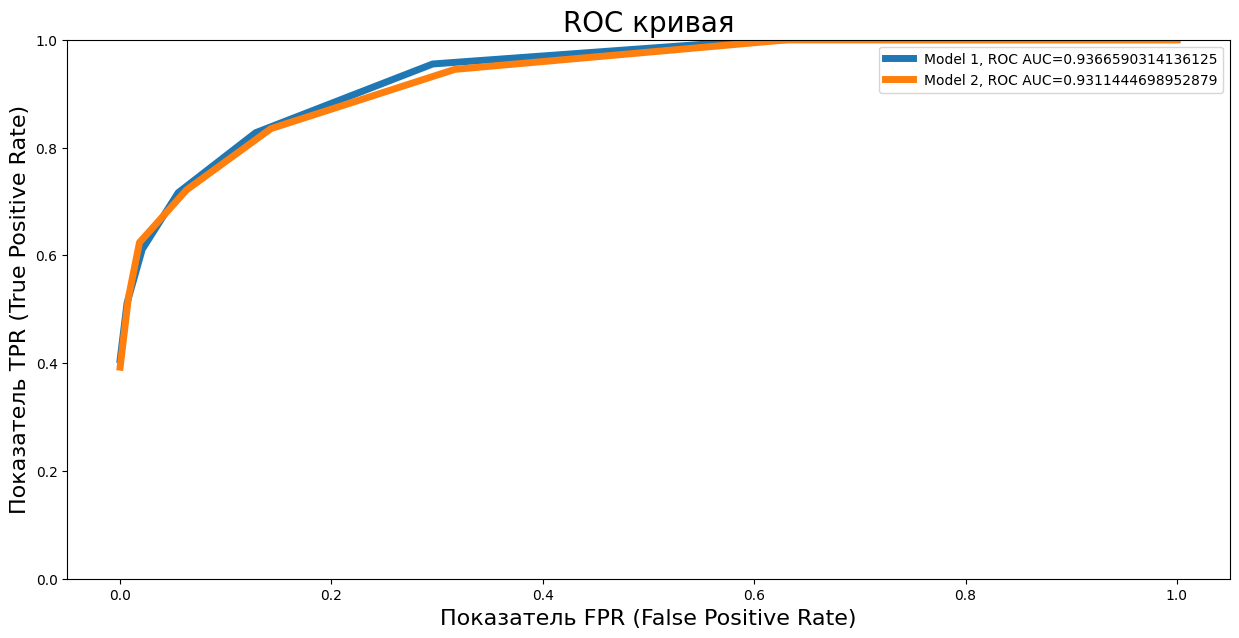

In [89]:
from sklearn.metrics import roc_auc_score

plt.figure(figsize=(15,7))

m1 = np.array([i[1] for i in knn1.predict_proba(encoded_imgs)])
m2 = np.array([i[1] for i in knn2.predict_proba(X_tr)])

r1 = roc_auc_score(y_train, m1)
r2 = roc_auc_score(y_train, m2)

ROC1 = roc_from_scratch(m1.reshape(-1),y_train,partitions=50)
plt.plot(ROC1[:,0],ROC1[:,1],lw=5, label='Model 1, ROC AUC=' + str(r1))

ROC2 = roc_from_scratch(m2.reshape(-1),y_train,partitions=50)
plt.plot(ROC2[:,0],ROC2[:,1],lw=5, label='Model 2, ROC AUC=' + str(r2))

plt.title('ROC кривая',fontsize=20)
plt.xlabel('Показатель FPR (False Positive Rate)',fontsize=16)
plt.ylabel('Показатель TPR (True Positive Rate)',fontsize=16)
plt.ylim(0,1);
plt.legend();

8. Визуализируйте границы принятия решений классификатора kNN для латентных признаков на плоскости, соответствующей двум первым латентным признакам (для прочих латентных признаков задайте средние/медианные значения).

In [90]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
    np.linspace(y_min, y_max, 100))
    X_in = np.c_[xx.ravel(), yy.ravel()]
    # X_in = np.concatenate((X_in, X[:10000,2:]), axis=1)
    X_in = np.concatenate((X_in[:1564, :], X[:10000, 2:]), axis=1)
    y_pred = model.predict(X_in)
    y_pred = np.round(y_pred)
    y_pred = np.resize(y_pred, xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [91]:
X.shape

(772, 32, 32)

In [92]:
X = encoded_imgs
X = pd.DataFrame(X)
x = X.median()
for i in range(2, 1024):
    X.loc[:, i] = x[i]

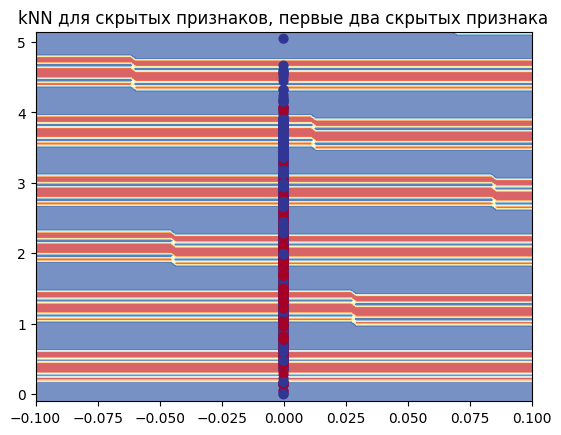

In [93]:
plt.title("kNN для скрытых признаков, первые два скрытых признака")
plot_decision_boundary(model=knn1, X=np.array(X), y=y_train)

9. Определите на первоначальной тестовой выборке изображение, имеющее наибольшую ошибку реконструкции. Выведите для этого изображения первоначальное и реконструированное изображения.  

In [94]:
X = X2.reshape(X2.shape[0], 32, 32)
X = X.astype('float32') / 255.
encoded_imgs = encoder.predict(X2)
decoded_imgs = decoder.predict(encoded_imgs)

25/25 [==============================] - 0s 4ms/step


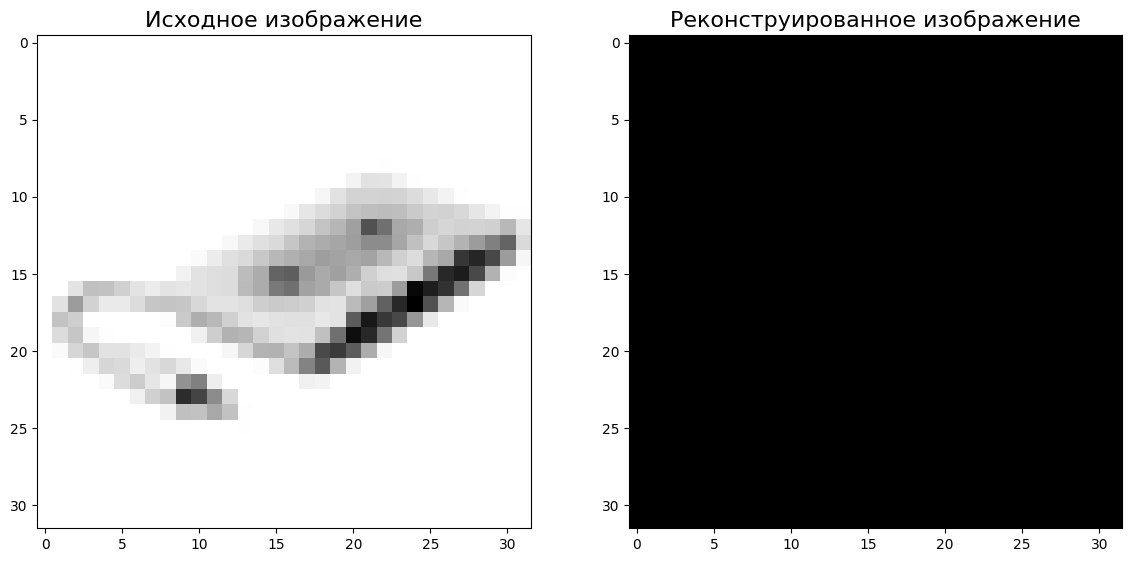

In [95]:
RE = ((X2 - decoded_imgs)**2).mean(axis = 1)
RE_original = RE.copy()
biggest_re_pos = np.argmax(RE_original)
fig = plt.figure(figsize = (14, 7))
ax = fig.add_subplot(1, 2, 1)
plt.title('Исходное изображение', fontsize = 16)
plt.imshow(X2[biggest_re_pos].reshape(32, 32),cmap='gray');
ax = fig.add_subplot(1, 2, 2)
plt.title('Реконструированное изображение', fontsize = 16)
plt.imshow(decoded_imgs[biggest_re_pos].reshape(32, 32),cmap='gray');